In [ ]:
# PaySim Fraud 분석 (RFM 기반 SQL 리서치)

---

## 1. RFM 분석 리서치

- **정의**:  
  Recency(최근성), Frequency(빈도), Monetary(금액) 세 가지 기준으로 고객 거래 행동을 분석하는 전통적 기법  

- **활용 분야**:  
  CRM(고객 관리), 마케팅 타겟팅, VIP 관리, 이탈 고객 식별, Fraud 탐지 보조 지표  

- **장점**:  
  단순하고 직관적, 데이터가 있으면 빠르게 계산 가능  

- **한계**:  
  고객 행동의 맥락이나 세밀한 변화를 모두 반영하기는 어려움 → 다른 데이터와 함께 쓰면 효과적  

📖 [RFM 분석이란 무엇일까요](https://brunch.co.kr/@datarian/151)

---

## 2. PaySim 데이터셋 분석 아이디어

- **데이터셋 특징**
  - 거래 단위 시간(step), 거래 금액(amount), 거래 유형(type), 송·수신자 ID(nameOrig, nameDest), 잔액 변화, 사기 여부(isFraud), 추가 변수(signup_step, isActivation, isReferral) 등으로 구성

- **RFM 매핑**
  - Recency: 고객별 마지막 거래 step과 기준 step 차이  
  - Frequency: 고객별 거래 횟수 (`COUNT(*) BY nameOrig`)  
  - Monetary: 고객별 거래 금액 합계(`SUM(amount)`) 또는 평균(`AVG(amount)`)

- **Fraud 탐지 응용**
  - 정상 고객: 일정한 RFM 패턴 (주기적 거래, 안정적 금액)  
  - Fraud 고객: Recency 짧음 + Frequency 급등 + Monetary 고액 집중  
  - 신규가입자(signup_step), 첫 거래(isActivation), 추천가입(isReferral)과 조합 →  
    “가입 직후 과도한 빈도·금액 거래” 패턴을 의심 거래로 태깅 가능


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt

# MySQL 연결 정보 
user = "root"
password = "doyeon5345"   
host = "localhost"
port = 3306
db = "paysim"       

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

print("✅ MySQL 연결 성공")


✅ MySQL 연결 성공


In [2]:
def run_query(query: str) -> pd.DataFrame:
    """
    MySQL에서 쿼리를 실행하고 Pandas DataFrame으로 반환
    """
    return pd.read_sql_query(query, engine)


In [3]:
# (1) 거래 현황 요약
#  - 전체 거래 건수, Fraud 건수, Fraud 비율 확인
#  - Fraud가 데이터셋에서 차지하는 비중이 얼마나 되는지 파악
query1 = """
SELECT 
    COUNT(*) AS total_txn,
    SUM(isFraud) AS fraud_txn,
    ROUND(SUM(isFraud)/COUNT(*), 4) AS fraud_rate
FROM paysim;
"""
df1 = run_query(query1)
df1

,total_txn,fraud_txn,fraud_rate
0,114957,171.0,0.0015


In [4]:
# (2) 거래 유형별 Fraud율
#  - type별 전체 건수와 Fraud 건수를 집계
#  - Fraud율이 높은 거래 유형(CASH-OUT, TRANSFER 등)을 식별
query2 = """
SELECT type,
       COUNT(*) AS total_count,
       SUM(isFraud) AS fraud_count,
       ROUND(SUM(isFraud)/COUNT(*), 4) AS fraud_rate
FROM paysim
GROUP BY type
ORDER BY fraud_rate DESC;
"""
df2 = run_query(query2)
df2

,type,total_count,fraud_count,fraud_rate
0,TRANSFER,9562,95.0,0.0099
1,CASH_OUT,40741,76.0,0.0019
2,CASH_IN,25514,0.0,0.0000
3,PAYMENT,38441,0.0,0.0000
4,DEBIT,699,0.0,0.0000


In [5]:
# (3) 고객별 RFM 요약
#  - 고객별로 Recency, Frequency, Monetary를 계산
#  - Fraud 여부(has_fraud)까지 태깅해서 고객군별 특징 분석 가능
#  - Recency = (데이터 마지막 step - 고객 마지막 거래 step)
query3 = """
SELECT
    nameOrig AS customer_id,
    MAX(step) AS last_step,
    ( (SELECT MAX(step) FROM paysim) - MAX(step) ) AS recency,
    COUNT(*) AS frequency,
    SUM(amount) AS total_monetary,
    AVG(amount) AS avg_monetary,
    MAX(isFraud) AS has_fraud
FROM paysim
GROUP BY nameOrig;
"""
df3 = run_query(query3)
df3.head()

,customer_id,last_step,recency,frequency,total_monetary,avg_monetary,has_fraud
0,C632336343,278,528,1,330218.42,330218.42,0
1,C1264712553,15,791,1,11647.08,11647.08,0
2,C1746846248,10,796,1,152264.21,152264.21,0
3,C333676753,403,403,1,1551760.63,1551760.63,0
4,C813403091,206,600,1,78172.30,78172.30,0


In [8]:
# (4) Fraud vs 정상 고객 평균 비교
#  - (3)에서 만든 RFM 결과를 Fraud 여부별 그룹화
#  - Fraud 고객군이 정상 고객군에 비해 Recency가 짧고,
#    Frequency/Monetary가 높은지 확인 가능

query4 = """
SELECT
    has_fraud,
    AVG(recency) AS avg_recency,
    AVG(frequency) AS avg_frequency,
    AVG(total_monetary) AS avg_total_monetary,
    AVG(avg_monetary) AS avg_avg_monetary
FROM (
    SELECT
        nameOrig AS customer_id,
        MAX(step) AS last_step,
        ( (SELECT MAX(step) FROM paysim) - MAX(step) ) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS total_monetary,
        AVG(amount) AS avg_monetary,
        MAX(isFraud) AS has_fraud
    FROM paysim
    GROUP BY nameOrig
) t
GROUP BY has_fraud;
"""

df4 = run_query(query4)
df4

,has_fraud,avg_recency,avg_frequency,avg_total_monetary,avg_avg_monetary
0,0,558.8884,1.1495,2.059302e+05,1.789318e+05
1,1,424.4752,1.2128,1.542737e+06,1.336081e+06


In [9]:
# (5) 시간대별 Fraud 추세
#  - step(시간 단위)별 전체 거래 건수와 Fraud 건수를 비교
#  - Fraud가 특정 시간대에 집중되는 패턴이 있는지 확인 가능

query5 = """
SELECT
    step,
    COUNT(*) AS total_txn,
    SUM(isFraud) AS fraud_txn
FROM paysim
GROUP BY step
ORDER BY step;
"""
df5 = run_query(query5)
df5.head()

,step,total_txn,fraud_txn
0,1,48,0.0
1,2,14,0.0
2,3,8,0.0
3,4,11,0.0
4,5,13,1.0


In [13]:
# (5) 시간대별 Fraud 추세
#  - step(시간 단위)별 전체 거래 건수와 Fraud 건수를 비교
#  - Fraud가 특정 시간대에 집중되는 패턴이 있는지 확인 가능

query5 = """
SELECT
    step,
    COUNT(*) AS total_txn,
    SUM(isFraud) AS fraud_txn
FROM paysim
GROUP BY step
ORDER BY step;
"""
df5 = run_query(query5)
df5.head()


,step,total_txn,fraud_txn
0,1,48,0.0
1,2,14,0.0
2,3,8,0.0
3,4,11,0.0
4,5,13,1.0


In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# ✅ 한글 폰트 설정 
plt.rc('font', family='AppleGothic')  # Mac

# ✅ 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

/var/folders/5k/08h9zsgd1hb9nkq4h530mqr80000gp/T/ipykernel_2150/3605251261.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x="type", y="fraud_rate", palette="Reds_r")


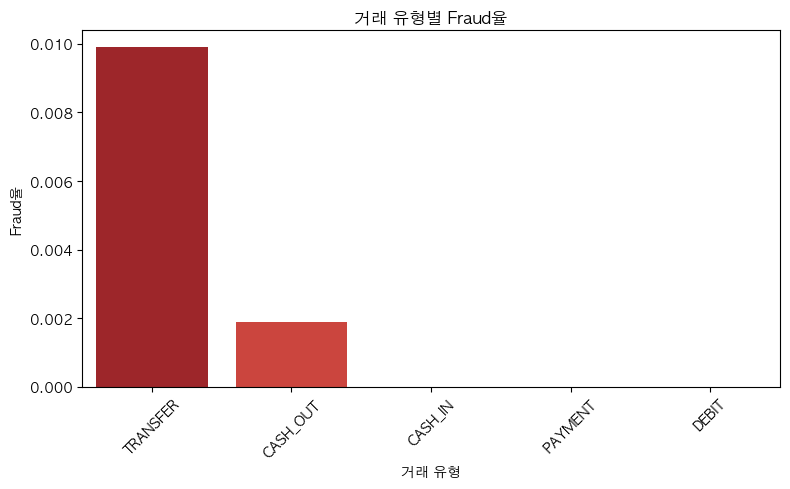

In [15]:
# 1) 거래 유형별 Fraud율 (막대 그래프)
plt.figure(figsize=(8,5))
sns.barplot(data=df2, x="type", y="fraud_rate", palette="Reds_r")
plt.title("거래 유형별 Fraud율")
plt.xlabel("거래 유형")
plt.ylabel("Fraud율")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

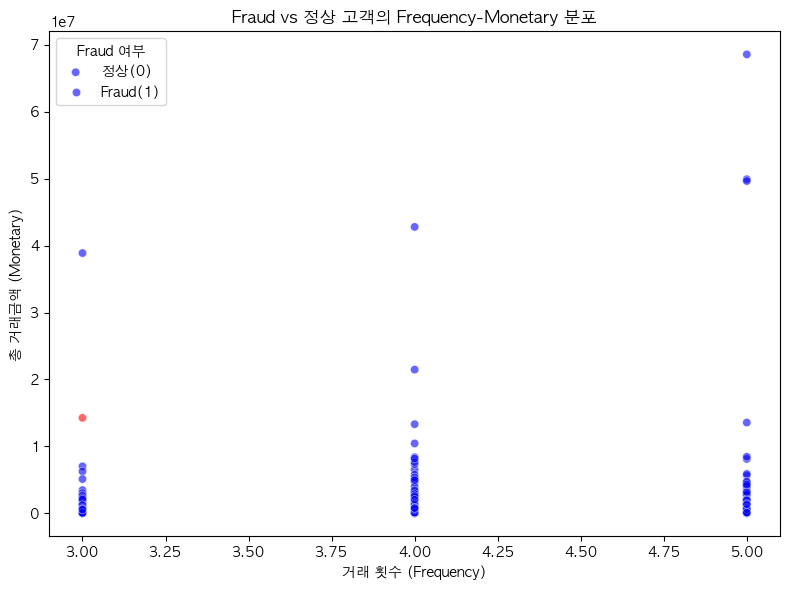

In [16]:
# 2) Fraud vs 정상 고객의 Frequency vs Monetary 분포 (산점도)
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df3.sample(2000, random_state=42),
    x="frequency", y="total_monetary",
    hue="has_fraud", palette={0:"blue", 1:"red"}, alpha=0.6
)
plt.title("Fraud vs 정상 고객의 Frequency-Monetary 분포")
plt.xlabel("거래 횟수 (Frequency)")
plt.ylabel("총 거래금액 (Monetary)")
plt.legend(title="Fraud 여부", labels=["정상(0)", "Fraud(1)"])
plt.tight_layout()
plt.show()